In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from scipy import misc, sparse, optimize, fft as scipy_fft
from matplotlib import pyplot, colors, cm
import embree
from pygltflib import GLTF2
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm, trange

cp.cuda.set_pinned_memory_allocator(None)
mempool = cp.get_default_memory_pool()

In [2]:
def srgb2lin(srgb):
        return np.where(srgb >= 0.04045, np.power((srgb + 0.055) / 1.055, 2.4), srgb/12.92)
    
def lin2srgb(lin):
    return np.where(lin > 0.0031308, 1.055 * np.power(lin, 1.0/2.4) - 0.055, 12.92 * lin)

class Material3D:
    def __init__(self, path, gltf, material):
        self.base_color = None
        self.metallic_roughness = None
        self.normal = None

        # Load base color texture.
        baseColorTexture = material.pbrMetallicRoughness.baseColorTexture
        if baseColorTexture is not None:
            texture = gltf.textures[baseColorTexture.index]
            source_image = gltf.images[texture.source]
            with Image.open(os.path.join(path, source_image.uri)) as img:
                self.base_color = np.swapaxes(np.array(img.convert('RGBA')), 0, 1)

        # Load metallic roughness texture.
        metallicRoughnessTexture = material.pbrMetallicRoughness.metallicRoughnessTexture
        if metallicRoughnessTexture is not None:
            texture = gltf.textures[metallicRoughnessTexture.index]
            source_image = gltf.images[texture.source]
            with Image.open(os.path.join(path, source_image.uri)) as img:
                self.metallic_roughness = np.swapaxes(np.array(img.convert('RGBA')), 0, 1)

        # Load normal map texture.
        normalTexture = material.normalTexture
        if normalTexture is not None:
            texture = gltf.textures[normalTexture.index]
            source_image = gltf.images[texture.source]
            with Image.open(os.path.join(path, source_image.uri)) as img:
                self.normal = np.swapaxes(np.array(img.convert('RGB')), 0, 1)

    def fetch_base_color(self, texcoord):
        # TexCoord wrapping.
        texcoord = texcoord % 1.0

        # Fetch base color texture.
        if self.base_color is not None:
            resolution = np.array(self.base_color.shape[:-1])
            indices = np.minimum(texcoord * resolution, resolution - 1).astype(int)
            base_color = self.base_color[indices[:, 0], indices[:, 1]] / 255.0
        else: # Use default values instead.
            base_color = np.array([1.0, 1.0, 1.0, 1.0])

        return base_color
        
    def fetch_metallic_roughness(self, texcoord):
        # TexCoord wrapping.
        texcoord = texcoord % 1.0
        
        # Fetch metallic roughness texture.
        if self.metallic_roughness is not None:
            resolution = np.array(self.metallic_roughness.shape[:-1])
            indices = np.minimum(texcoord * resolution, resolution - 1).astype(int)
            metallic_roughness = self.metallic_roughness[indices[:, 0], indices[:, 1]] / 255.0
            #metallic_roughness = self.srgb2lin(metallic_roughness)
            metallic = metallic_roughness[:, 2:3]
            roughness = metallic_roughness[:, 1:2]
        else: # Use default factors instead.
            metallic = 1.0
            roughness = 1.0

        return [metallic, roughness]
    
    def fetch_normal(self, texcoord):
        # TexCoord wrapping.
        texcoord = texcoord % 1.0

        # Fetch normal map texture.
        if self.normal is not None:
            resolution = np.array(self.normal.shape[:-1])
            indices = np.minimum(texcoord * resolution, resolution - 1).astype(int)
            normal = (self.normal[indices[:, 0], indices[:, 1]] / 255.0) * 2.0 - 1.0
        else: # Use the interpolated vertex normal instead.
            normal = np.array([0.0, 0.0, 1.0])

        return normal

class Mesh3D:
    def __init__(self, gltf, primitive, rotation, translation):
        self.position = None
        self.texcoord = None
        self.normal = None
        self.tangent = None
        self.bitangent = None
        self.indices = None
        self.material = primitive.material

        # Load position attribute.
        if primitive.attributes.POSITION is not None:
            accessor = gltf.accessors[primitive.attributes.POSITION]
            bufferView = gltf.bufferViews[accessor.bufferView]
            buffer = gltf.buffers[bufferView.buffer]
            data = gltf.get_data_from_buffer_uri(buffer.uri)
            self.position = np.frombuffer(data, dtype='float32', count=3*accessor.count, offset=bufferView.byteOffset+accessor.byteOffset).reshape(accessor.count, 3)
            self.position = (self.position @ rotation.T) + translation

        # Load texcoord attribute.
        if primitive.attributes.TEXCOORD_0 is not None:
            accessor = gltf.accessors[primitive.attributes.TEXCOORD_0]
            bufferView = gltf.bufferViews[accessor.bufferView]
            buffer = gltf.buffers[bufferView.buffer]
            data = gltf.get_data_from_buffer_uri(buffer.uri)
            self.texcoord = np.frombuffer(data, dtype='float32', count=2*accessor.count, offset=bufferView.byteOffset+accessor.byteOffset).reshape(accessor.count, 2)

        # Load normal attribute.
        if primitive.attributes.NORMAL is not None:
            accessor = gltf.accessors[primitive.attributes.NORMAL]
            bufferView = gltf.bufferViews[accessor.bufferView]
            buffer = gltf.buffers[bufferView.buffer]
            data = gltf.get_data_from_buffer_uri(buffer.uri)
            self.normal = np.frombuffer(data, dtype='float32', count=3*accessor.count, offset=bufferView.byteOffset+accessor.byteOffset).reshape(accessor.count, 3)
            self.normal = self.normal @ rotation.T

        # Load tangent attribute.
        if primitive.attributes.TANGENT is not None:
            accessor = gltf.accessors[primitive.attributes.TANGENT]
            bufferView = gltf.bufferViews[accessor.bufferView]
            buffer = gltf.buffers[bufferView.buffer]
            data = gltf.get_data_from_buffer_uri(buffer.uri)
            tangent = np.frombuffer(data, dtype='float32', count=4*accessor.count, offset=bufferView.byteOffset+accessor.byteOffset).reshape(accessor.count, 4)
            self.tangent = tangent[..., 0:3] @ rotation.T
            if self.normal is not None:
                self.bitangent = np.cross(self.normal, self.tangent) * tangent[..., 3:4]

        # Load vertex indices.
        if primitive.indices is not None:
            accessor = gltf.accessors[primitive.indices]
            bufferView = gltf.bufferViews[accessor.bufferView]
            buffer = gltf.buffers[bufferView.buffer]
            data = gltf.get_data_from_buffer_uri(buffer.uri)
            self.indices = np.frombuffer(data, dtype='uint16', count=accessor.count, offset=bufferView.byteOffset+accessor.byteOffset).reshape(accessor.count//3, 3).astype(np.uint32)

    def interpolate_texcoord(self, prim_id, uv):
        indices = self.indices[prim_id]

        if self.texcoord is not None:
            texcoord = self.texcoord[indices, ...]
            texcoord = (1.0 - uv[..., np.newaxis, 0] - uv[..., np.newaxis, 1]) * texcoord[:, 0, :] + uv[..., np.newaxis, 0] * texcoord[:, 1, :] + uv[..., np.newaxis, 1] * texcoord[:, 2, :]
        else:
            texcoord = np.array([0.0, 0.0])

        return texcoord

    def interpolate_tbn(self, prim_id, uv):
        indices = self.indices[prim_id]
        position = self.position[indices, ...]

        if self.tangent is not None:
            tangent = self.tangent[indices, ...]
            tangent = (1.0 - uv[..., np.newaxis, 0] - uv[..., np.newaxis, 1]) * tangent[:, 0, :] + uv[..., np.newaxis, 0] * tangent[:, 1, :] + uv[..., np.newaxis, 1] * tangent[:, 2, :]
        else:
            tangent = position[:, 1, :] - position[:, 0, :] # V0->V1

        if self.bitangent is not None:
            bitangent = self.bitangent[indices, ...]
            bitangent = (1.0 - uv[..., np.newaxis, 0] - uv[..., np.newaxis, 1]) * bitangent[:, 0, :] + uv[..., np.newaxis, 0] * bitangent[:, 1, :] + uv[..., np.newaxis, 1] * bitangent[:, 2, :]
        else:
            bitangent = position[:, 2, :] - position[:, 0, :] # V0->V2

        if self.normal is not None:
            normal = self.normal[indices, ...]
            normal = (1.0 - uv[..., np.newaxis, 0] - uv[..., np.newaxis, 1]) * normal[:, 0, :] + uv[..., np.newaxis, 0] * normal[:, 1, :] + uv[..., np.newaxis, 1] * normal[:, 2, :]
        else:
            normal = np.cross(tangent, bitangent)

        normal /= np.sqrt(np.einsum('...i,...i', normal, normal))[:, np.newaxis] # normalize

        tangent -= np.einsum('...i,...i', tangent, normal)[:, np.newaxis] * normal # Gram-Schmidt
        tangent /= np.sqrt(np.einsum('...i,...i', tangent, tangent))[:, np.newaxis] # normalize

        bitangent -= np.einsum('...i,...i', bitangent, normal)[:, np.newaxis] * normal # Gram-Schmidt
        bitangent -= np.einsum('...i,...i', bitangent, tangent)[:, np.newaxis] * tangent # Gram-Schmidt
        bitangent /= np.sqrt(np.einsum('...i,...i', bitangent, bitangent))[:, np.newaxis] # normalize

        return [tangent, bitangent, normal]

class Scene3D:
    def __init__(self, filename, rotation, translation):
        self.device = embree.Device()
        self.scene = self.device.make_scene()

        path = os.path.dirname(filename)
        gltf = GLTF2().load(filename)

        self.materials = []
        for gltf_material in gltf.materials:
            material = Material3D(path, gltf, gltf_material)
            self.materials.append(material)

        self.meshes = []
        for gltf_mesh in gltf.meshes:
            for primitive in gltf_mesh.primitives:
                mesh = Mesh3D(gltf, primitive, rotation, translation)
                self.meshes.append(mesh)

                geometry = self.device.make_geometry(embree.GeometryType.Triangle)

                vertex_buffer = geometry.set_new_buffer(embree.BufferType.Vertex, 0, embree.Format.Float3, 3 * np.dtype('float32').itemsize, mesh.position.shape[0])
                vertex_buffer[:] = mesh.position

                index_buffer = geometry.set_new_buffer(embree.BufferType.Index, 0, embree.Format.Uint3, 3 * np.dtype('uint32').itemsize, mesh.indices.shape[0])
                index_buffer[:] = mesh.indices

                geometry.commit()
                self.scene.attach_geometry(geometry)
                geometry.release()

        self.scene.commit()

    def rayCast(self, ray_origins, ray_directions, light_positions, light_values):
        n_rays = ray_origins.shape[0]

        ray_color = np.zeros((n_rays, 3), dtype=np.float32)

        rayhits = embree.RayHit1M(ray_origins.shape[0])
        rayhits.org[:] = ray_origins
        rayhits.dir[:] = ray_directions / np.sqrt(np.einsum('...i,...i', ray_directions, ray_directions))[:, np.newaxis]
        rayhits.tfar[:] = 0
        rayhits.flags[:] = 0

        context = embree.IntersectContext()

        active_rays = np.ones(n_rays, dtype=bool)

        while np.any(active_rays):
            rayhits.prim_id[active_rays] = embree.INVALID_GEOMETRY_ID
            rayhits.geom_id[active_rays] = embree.INVALID_GEOMETRY_ID
            rayhits.tnear[active_rays] = rayhits.tfar[active_rays] + 0.01
            rayhits.tfar[active_rays] = np.inf
            rayhits.tfar[~active_rays] = 0

            self.scene.intersect1M(context, rayhits)

            # Check for active rays that hit the scene.
            ray_color[active_rays] = [48.0/255, 53.0/255, 66.0/255] # Background color.
            active_rays[active_rays] = (rayhits.geom_id[active_rays] != embree.INVALID_GEOMETRY_ID)
            ray_color[active_rays] = 0.0

            for mesh_id in range(len(self.meshes)):
                mesh = self.meshes[mesh_id]
                material = self.materials[mesh.material]

                # Create mask with current mesh hits.
                mask = np.zeros(n_rays, dtype=bool)
                mask[active_rays] = (rayhits.geom_id[active_rays] == mesh_id)

                # Interpolate TexCoord vertex attribute.
                texcoord = mesh.interpolate_texcoord(rayhits.prim_id[mask], rayhits.uv[mask, :])

                # Fetch base color texture.
                base_color = material.fetch_base_color(texcoord)

                # Futher restrict mask to opaque hits.
                opaque = (base_color[..., 3] > 0.5)
                mask[mask] = opaque
                texcoord = texcoord[opaque]
                base_color = base_color[opaque, 0:3]

                # Interpolate TBN vertex attributes.
                tangent, bitangent, normal = mesh.interpolate_tbn(rayhits.prim_id[mask], rayhits.uv[mask, :])

                # Fetch normal map texture.
                normal_tanspace = material.fetch_normal(texcoord)
                normal_vector = normal_tanspace[..., 0:1] * tangent + normal_tanspace[..., 1:2] * bitangent + normal_tanspace[..., 2:3] * normal
                normal_vector /= np.sqrt(np.einsum('...i,...i', normal_vector, normal_vector))[:, np.newaxis] # normalize

                # Fetch metallic roughness texture.
                metallic, roughness = material.fetch_metallic_roughness(texcoord)

                # Normalized view direction.
                view_vector = -rayhits.dir[mask]

                # Compute hit positions.
                position = rayhits.org[mask] + rayhits.dir[mask] * rayhits.tfar[mask, np.newaxis]

                for light_id in range(light_positions.shape[0]):
                    # Normalized light direction.
                    light_vector = light_positions[light_id] - position
                    light_distance = np.sqrt(np.einsum('...i,...i', light_vector, light_vector))[:, np.newaxis]
                    light_vector /= light_distance # normalize

                    light_vector = -light_positions[light_id]
                    #light_vector /= np.sqrt(np.einsum('...i,...i', light_vector, light_vector)) # normalize

                    # Accumulate for each light.
                    ray_color[mask] +=  self.brdf_shading(view_vector, light_vector, normal_vector, metallic, roughness, base_color) * light_values[light_id]

                # Deactivate shaded rays.
                active_rays[mask] = False
        
        return ray_color
    
    def brdf_shading(self, view_vector, light_vector, normal_vector, metallic, roughness, base_color):
        alpha2 = roughness**4

        halfway_vector = view_vector + light_vector
        halfway_vector /= np.sqrt(np.einsum('...i,...i', halfway_vector, halfway_vector))[:, np.newaxis]

        NdotH = np.clip(np.einsum('...i,...i', normal_vector, halfway_vector), 0.0, 1.0)[:, np.newaxis]
        LdotH = np.clip(np.einsum('...i,...i', light_vector, halfway_vector), 0.0, 1.0)[:, np.newaxis]
        VdotH = np.clip(np.einsum('...i,...i', view_vector, halfway_vector), 0.0, 1.0)[:, np.newaxis]
        LdotN = np.clip(np.einsum('...i,...i', light_vector, normal_vector), 0.0, 1.0)[:, np.newaxis]
        VdotN = np.clip(np.einsum('...i,...i', view_vector, normal_vector), 0.0, 1.0)[:, np.newaxis]

        distribution = (alpha2 / np.pi) / np.square(np.square(NdotH) * (alpha2 - 1.0) + 1.0)

        ggx_v = LdotN * np.sqrt(np.square(VdotN) * (1.0 - alpha2) + alpha2)
        ggx_l = VdotN * np.sqrt(np.square(LdotN) * (1.0 - alpha2) + alpha2)
        ggx_vl = ggx_v + ggx_l
        visibility = np.divide(0.5, ggx_vl, out=np.zeros_like(ggx_vl), where=~np.isclose(ggx_vl, 0.0))

        dielectric_fresnel = 0.04 + (1.0 - 0.04) * np.power(1.0 - VdotH, 5)
        metal_fresnel = base_color + (1.0 - base_color) * np.power(1.0 - VdotH, 5)

        mixed_fresnel = (1.0 - metallic) * dielectric_fresnel + metallic * metal_fresnel

        difuse_color = (1.0 - dielectric_fresnel) * (1.0 - metallic) * base_color / np.pi
        specular_color = mixed_fresnel * distribution * visibility

        color = (difuse_color + specular_color) * LdotN

        return color
    
    def release(self):
        self.scene.release()
        self.device.release()

In [3]:
def array_stats(a):
    print('shape: ', a.shape, a.dtype, '| total size:', a.nbytes/2**30, 'GiB | range: [', np.amin(a), ',', np.amax(a), '] | average: ', np.average(a))


    
def display_image(values, color_map=None, absolute=True, normalize=True, shift=False, flip=False):
    """Display an array as an image using a color map. The image can be normalized, shifted and/or flipped."""
    values = values.T
    values = np.abs(values) if absolute else values
    values = scipy_fft.fftshift(values) if shift else values
    values = np.flip(values, axis=1) if flip else np.flip(values, axis=0)
    if len(values.shape) < 3:
        values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else np.clip(values, 0.0, 1.0)
        values = cm.get_cmap(color_map)(values, bytes=True)
    else:
        values = (values * np.nan_to_num(255.0 / np.amax(values))).astype(np.uint8) if normalize else np.clip(values * 255.0, 0.0, 255.0).astype(np.uint8)
    display(Image.fromarray(values))

shape:  (1048576, 3) float32 | total size: 0.01171875 GiB | range: [ 7.869124e-07 , 1298.1196 ] | average:  0.3238488


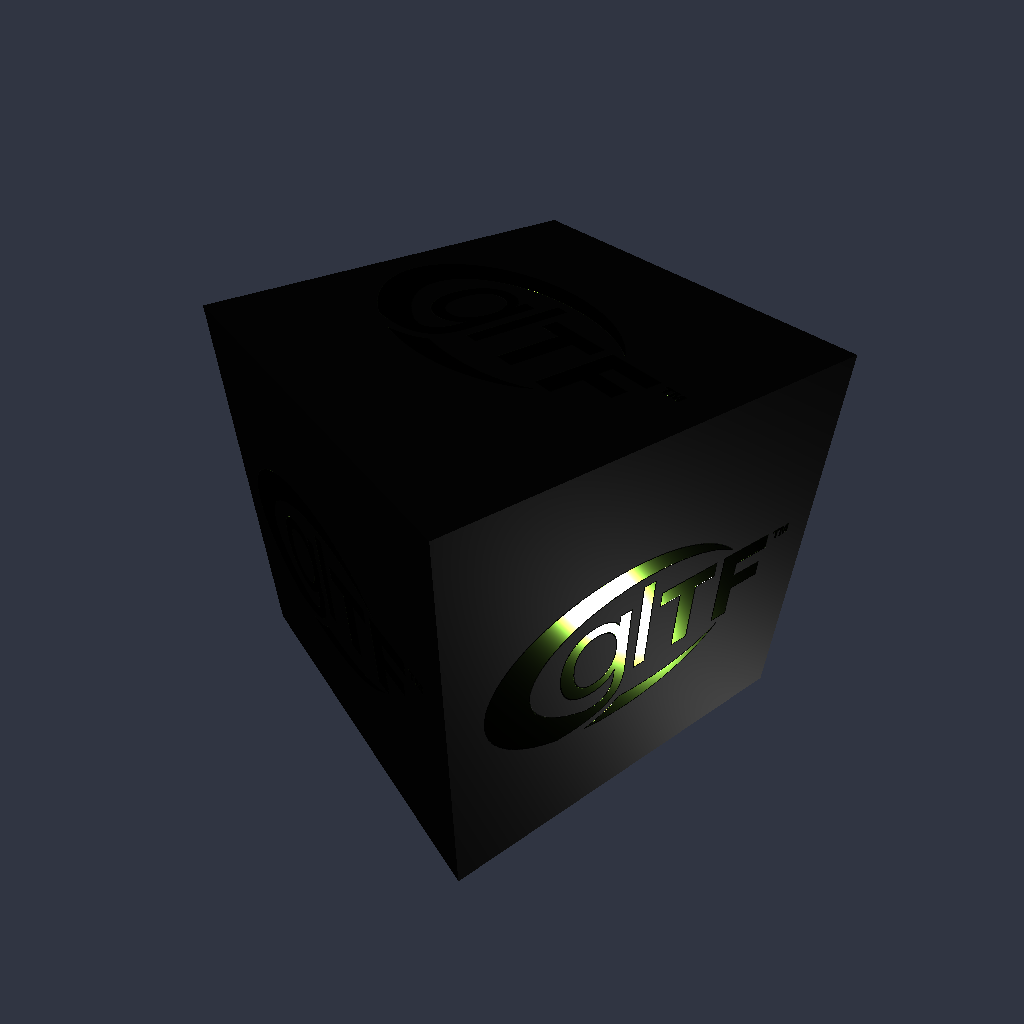

shape:  (1048576, 3) float32 | total size: 0.01171875 GiB | range: [ 1.0166908e-05 , 20.860434 ] | average:  0.43466222


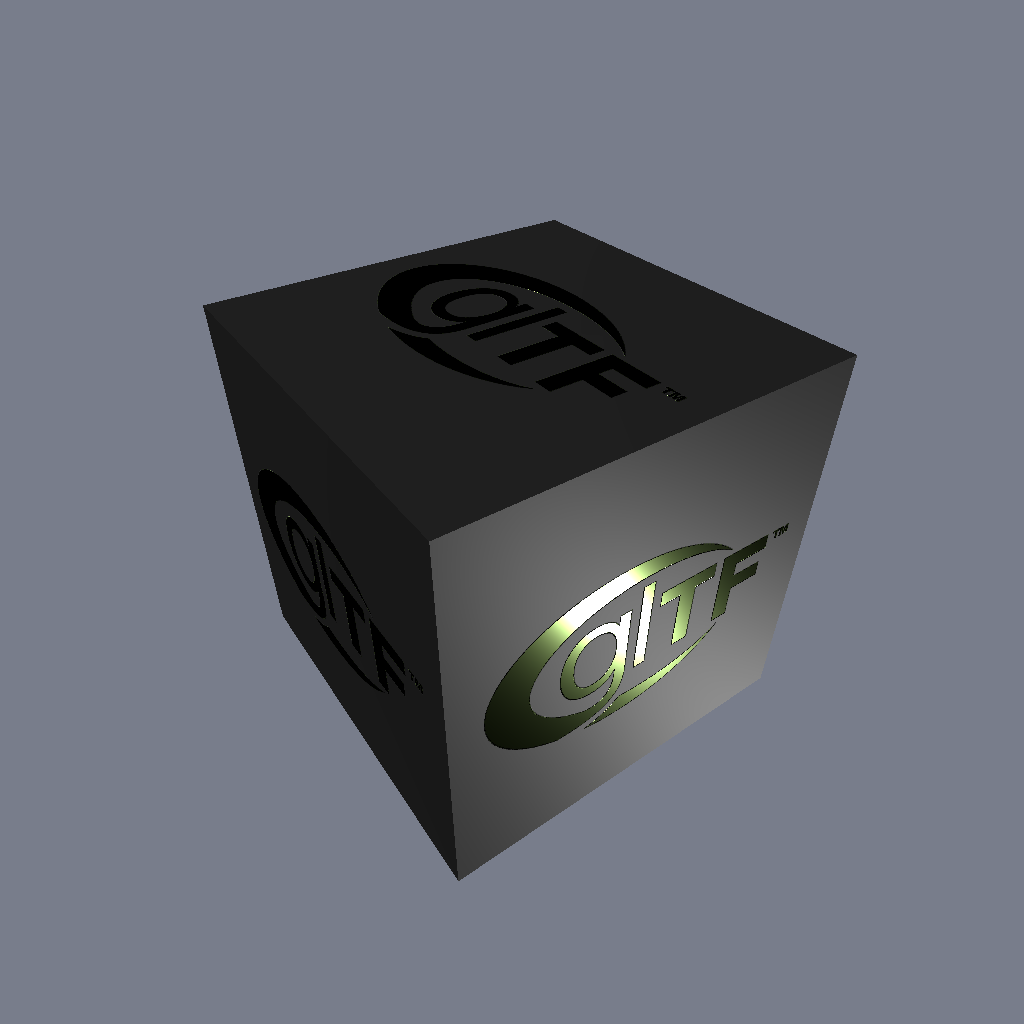

In [4]:
retina_size = 22.0

rotation = np.array([[0.5771551728248596, 0.0, -0.8166345357894897],
                     [-0.5085397958755493, 0.7824397683143616, -0.3594096899032593],
                     [0.6389673352241516, 0.6227262616157532, 0.4515891671180725]])

#translation = np.array([-120.0, -200.0, -800.0])
translation = np.array([0.0, 0.0, -4.0])

#scene = Scene3D('../models/gltf/sponza/Sponza.gltf', rotation, translation)
scene = Scene3D('../models/gltf/BoxWithoutSpaces/BoxWithoutSpaces.gltf', rotation, translation)

res_x = 1024
res_y = 1024

org_x = np.zeros(res_x * res_y, dtype=cp.float32)
org_y = np.zeros(res_x * res_y, dtype=cp.float32)
org_z = np.zeros(res_x * res_y, dtype=cp.float32)

dst_x = np.repeat(np.linspace(-0.5, 0.5, num=res_x) * retina_size, res_y)
dst_y = np.tile(np.linspace(-0.5, 0.5, num=res_y) * retina_size, res_x)
dst_z = np.ones(res_x * res_y, dtype=cp.float32) * (-17.0)

ray_origins = np.stack(np.broadcast_arrays(org_x, org_y, org_z), axis=-1)
ray_directions = np.stack(np.broadcast_arrays(dst_x, dst_y, dst_z), axis=-1) - ray_origins



light_positions = np.array([[0.5, -0.7, -0.5], [-0.5, 0.7, 0.5]]) @ rotation.T
light_values = np.array([[0.5, 0.5, 0.5], [1.0, 1.0, 1.0]])

ray_color = scene.rayCast(ray_origins, ray_directions, light_positions, light_values)

array_stats(ray_color)
display_image(np.moveaxis(ray_color, -1, 0).reshape(3, res_x, res_y), normalize=False)

ray_color = lin2srgb(ray_color)

array_stats(ray_color)
display_image(np.moveaxis(ray_color, -1, 0).reshape(3, res_x, res_y), normalize=False)



scene.release()